<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Split-based-on-spoken-proportion" data-toc-modified-id="Split-based-on-spoken-proportion-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Split based on spoken proportion</a></span></li><li><span><a href="#Extract-NER-tags" data-toc-modified-id="Extract-NER-tags-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Extract NER tags</a></span></li><li><span><a href="#Multilingual-Transformers-with-XLM-R" data-toc-modified-id="Multilingual-Transformers-with-XLM-R-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Multilingual Transformers with XLM-R</a></span></li><li><span><a href="#Tokenization" data-toc-modified-id="Tokenization-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Tokenization</a></span><ul class="toc-item"><li><span><a href="#Sentence-Piece-vs-WordPiece" data-toc-modified-id="Sentence-Piece-vs-WordPiece-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Sentence Piece vs WordPiece</a></span></li><li><span><a href="#Tokenizer-Pipeline" data-toc-modified-id="Tokenizer-Pipeline-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Tokenizer Pipeline</a></span></li><li><span><a href="#Sentencepiece-tokenizer" data-toc-modified-id="Sentencepiece-tokenizer-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Sentencepiece tokenizer</a></span></li></ul></li><li><span><a href="#Transformers-for-NER-and-the-inner-working-of-HuggingFace-Transformers" data-toc-modified-id="Transformers-for-NER-and-the-inner-working-of-HuggingFace-Transformers-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Transformers for NER and the inner working of HuggingFace Transformers</a></span><ul class="toc-item"><li><span><a href="#Body-and-Head" data-toc-modified-id="Body-and-Head-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Body and Head</a></span></li><li><span><a href="#Create-custom-model" data-toc-modified-id="Create-custom-model-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Create custom model</a></span></li><li><span><a href="#Adjust-config-file" data-toc-modified-id="Adjust-config-file-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Adjust config file</a></span></li><li><span><a href="#Load-the-custom-model" data-toc-modified-id="Load-the-custom-model-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Load the custom model</a></span></li></ul></li><li><span><a href="#Tokenization-for-NER" data-toc-modified-id="Tokenization-for-NER-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Tokenization for NER</a></span></li><li><span><a href="#Define-metrics" data-toc-modified-id="Define-metrics-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Define metrics</a></span></li><li><span><a href="#Finetuning-XLM-R" data-toc-modified-id="Finetuning-XLM-R-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Finetuning XLM-R</a></span><ul class="toc-item"><li><span><a href="#Setting-up" data-toc-modified-id="Setting-up-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Setting up</a></span></li><li><span><a href="#Error-analysis" data-toc-modified-id="Error-analysis-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>Error analysis</a></span></li></ul></li><li><span><a href="#Cross-lingual-transfer" data-toc-modified-id="Cross-lingual-transfer-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Cross-lingual transfer</a></span></li><li><span><a href="#When-to-use-Zero-shot-transfer" data-toc-modified-id="When-to-use-Zero-shot-transfer-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>When to use Zero-shot transfer</a></span></li><li><span><a href="#Fine-Tuning-on-Multiple-Languages-at-Once" data-toc-modified-id="Fine-Tuning-on-Multiple-Languages-at-Once-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Fine-Tuning on Multiple Languages at Once</a></span><ul class="toc-item"><li><span><a href="#Concatenate-dataset" data-toc-modified-id="Concatenate-dataset-12.1"><span class="toc-item-num">12.1&nbsp;&nbsp;</span>Concatenate dataset</a></span></li><li><span><a href="#train-model" data-toc-modified-id="train-model-12.2"><span class="toc-item-num">12.2&nbsp;&nbsp;</span>train model</a></span></li><li><span><a href="#comparing-the-performance-of-fine-tuning-on-each-language-separately-against-multilingual-learning-on-all-the-corpora" data-toc-modified-id="comparing-the-performance-of-fine-tuning-on-each-language-separately-against-multilingual-learning-on-all-the-corpora-12.3"><span class="toc-item-num">12.3&nbsp;&nbsp;</span>comparing the performance of fine-tuning on each language separately against multilingual learning on all the corpora</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

Multilingual transformers: Like BERT, these models use **masked language modeling** as a pretraining objective, but they are trained **jointly on texts in over one hundred languages** (huge corpora across many languages)

=> a model that is fine-tuned on one language can be applied to others without any further training

=> these multilingual transformers enable zero-shot cross-lingual transfer


a single transformer model called XLM-RoBERTa (introduced in Chapter 3)1 can be fine-tuned to perform named entity recognition (NER) across several languages


Note: Zero-shot transfer or zero-shot learning usually refers to the task of training a model on one set of labels and then evaluating it on a different set of labels. In the context of transformers, zero-shot learning may also refer to situations where a language model like GPT-3 is evaluated on a downstream task that it wasn’t even fine-tuned on.


For this chapter let’s assume that we want to perform NER for a customer based in Switzerland, where there are four national languages (with English often serving as a bridge between them). Let’s start by getting a suitable multilingual corpus for this problem.

# Load data

Each article is annotated with 
- LOC (location), 
- PER (person), and 
- ORG (organization) tags 
- in the “inside-outside-beginning” (IOB2) format. 
    - In this format, a B- prefix indicates the beginning of an entity, and consecutive tokens belonging to the same entity are given an I- prefix. 
- An O tag indicates that the token does not belong to any entity

We will be using a subset of the Cross-lingual TRansfer Evaluation of Multilingual Encoders (XTREME) benchmark called WikiANN or PAN-X

In [1]:
from datasets import load_dataset
from datasets import get_dataset_config_names


In [2]:

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

XTREME has 183 configurations


In [3]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets

['PAN-X.af',
 'PAN-X.ar',
 'PAN-X.bg',
 'PAN-X.bn',
 'PAN-X.de',
 'PAN-X.el',
 'PAN-X.en',
 'PAN-X.es',
 'PAN-X.et',
 'PAN-X.eu',
 'PAN-X.fa',
 'PAN-X.fi',
 'PAN-X.fr',
 'PAN-X.he',
 'PAN-X.hi',
 'PAN-X.hu',
 'PAN-X.id',
 'PAN-X.it',
 'PAN-X.ja',
 'PAN-X.jv',
 'PAN-X.ka',
 'PAN-X.kk',
 'PAN-X.ko',
 'PAN-X.ml',
 'PAN-X.mr',
 'PAN-X.ms',
 'PAN-X.my',
 'PAN-X.nl',
 'PAN-X.pt',
 'PAN-X.ru',
 'PAN-X.sw',
 'PAN-X.ta',
 'PAN-X.te',
 'PAN-X.th',
 'PAN-X.tl',
 'PAN-X.tr',
 'PAN-X.ur',
 'PAN-X.vi',
 'PAN-X.yo',
 'PAN-X.zh']

To make a realistic Swiss corpus, we’ll sample the German (de), French (fr), Italian (it), and English (en) corpora from PAN-X according to their spoken proportions. This will create a language imbalance that is very common in real-world datasets

In [4]:
tmp = load_dataset("xtreme", name=f"PAN-X.vi")

Reusing dataset xtreme (/home/quan/.cache/huggingface/datasets/xtreme/PAN-X.vi/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
tmp

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [6]:
tmp['train']['tokens'][:10]

[['Đồng', 'bằng', 'sông', 'Cửu', 'Long'],
 ['Trần', 'Trọng', 'Kim', ',', "''Đường", 'thi', "''", '.'],
 ['Gaushorn', '(', '213', ')'],
 ['10.17', '-', "'", "''", 'Wonder', 'Girls15th', '-', 'Nobody3rd', "''", "'"],
 ['đổi', 'CJ', 'E', '&', 'M', 'Pictures'],
 ['Đây',
  'là',
  'loài',
  'bản',
  'địa',
  'của',
  'Argentina',
  ',',
  'Brasil',
  ',',
  'và',
  'Paraguay',
  '.'],
 ['Sân',
  'vận',
  'động',
  'chính',
  'Khu',
  'liên',
  'hợp',
  'thể',
  'thao',
  'quốc',
  'gia',
  'Lào'],
 ['Kia]]', ',', 'Mazda', ',', 'BMW'],
 ["''", "'", "''", "'", '-', 'Gustavo', 'Gianetti'],
 ["''", 'Senecio', 'nevadensis', "''", 'Boiss', '.']]

# Split based on spoken proportion

In [7]:
from collections import defaultdict
from datasets import DatasetDict

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]
# Return a DatasetDict if a key doesn't exist
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # Load monolingual corpus
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # Shuffle and downsample each split according to spoken proportion
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=0)
            .select(range(int(frac * ds[split].num_rows))))

Reusing dataset xtreme (/home/quan/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-ad1b311e95818edf.arrow
Loading cached shuffled indices for dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-9e4b5e384626785e.arrow
Loading cached shuffled indices for dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-b80ca41f318cd7e7.arrow
Reusing dataset xtreme (/home/quan/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-222f2a739e50779b.arrow
Loading cached shuffled indices for dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-ae79577dfb0e7498.arrow
Loading cached shuffled indices for dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-0bc206f54324de18.arrow
Reusing dataset xtreme (/home/quan/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-2a286f85a785394c.arrow
Loading cached shuffled indices for dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-55894a1d8ab171ae.arrow
Loading cached shuffled indices for dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-b2a9c20bbec1f943.arrow
Reusing dataset xtreme (/home/quan/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-b91db9df81081a1f.arrow
Loading cached shuffled indices for dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-dea8d95ed2e6a82a.arrow
Loading cached shuffled indices for dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-56dba7892a30e39c.arrow


In [8]:
panx_ch.keys(),panx_ch['de']

(dict_keys(['de', 'fr', 'it', 'en']),
 DatasetDict({
     train: Dataset({
         features: ['tokens', 'ner_tags', 'langs'],
         num_rows: 12580
     })
     validation: Dataset({
         features: ['tokens', 'ner_tags', 'langs'],
         num_rows: 6290
     })
     test: Dataset({
         features: ['tokens', 'ner_tags', 'langs'],
         num_rows: 6290
     })
 }))

In [9]:
import pandas as pd

pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
             index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


we have more examples in German than all other languages combined, so we’ll use it as a starting point from which to perform zero-shot cross-lingual transfer to French, Italian, and English.

In [10]:
panx_ch["de"]["train"][0]

{'tokens': ['2.000',
  'Einwohnern',
  'an',
  'der',
  'Danziger',
  'Bucht',
  'in',
  'der',
  'polnischen',
  'Woiwodschaft',
  'Pommern',
  '.'],
 'ner_tags': [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0],
 'langs': ['de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de']}

In [11]:
panx_ch["de"]["train"].features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None),
 'langs': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

# Extract NER tags

In [12]:
# extract ner_tags
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


Note: function to put in `map` function for DatasetDict should have this signature

`function(examples: Dict[str, List]) -> Dict[str, List]`

In [13]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

In [14]:
# convert from ner_tags to string
panx_ch['de']['train'][0],create_tag_names(panx_ch['de']['train'][0])

({'tokens': ['2.000',
   'Einwohnern',
   'an',
   'der',
   'Danziger',
   'Bucht',
   'in',
   'der',
   'polnischen',
   'Woiwodschaft',
   'Pommern',
   '.'],
  'ner_tags': [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0],
  'langs': ['de',
   'de',
   'de',
   'de',
   'de',
   'de',
   'de',
   'de',
   'de',
   'de',
   'de',
   'de']},
 {'ner_tags_str': ['O',
   'O',
   'O',
   'O',
   'B-LOC',
   'I-LOC',
   'O',
   'O',
   'B-LOC',
   'B-LOC',
   'I-LOC',
   'O']})

In [15]:
# go through the entire de
panx_de = panx_ch["de"].map(create_tag_names)

Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-55acd4c0c78d0f11.arrow
Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-b74f4b8beefbe2d4.arrow
Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-0d2a1d8035c7d0e3.arrow


In [16]:
panx_de

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
})

In [17]:
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]],
['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


As a quick check that we don’t have any unusual imbalance in the tags, let’s calculate the frequencies of each entity across each split:

In [18]:
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


# Multilingual Transformers with XLM-R

A remarkable feature of this approach is that **despite receiving no explicit information to differentiate among the languages, the resulting linguistic representations are able to generalize well across languages** for a variety of downstream tasks

Multilingual transformer models are usually evaluated in three different ways:

- en
    - Fine-tune on the English training data and then evaluate on each language’s test set.

- each
    - Fine-tune and evaluate on monolingual test data to measure per-language performance.

- all
    - Fine-tune on all the training data to evaluate on all on each language’s test set.

XLM-R uses only MLM as a pretraining objective for 100 languages, but is distinguished by the huge size of its pretraining corpus compared to its predecessors: Wikipedia dumps for each language and 2.5 terabytes of Common Crawl data from the web. 

The 'R' (RoBERTa) improved on several aspects of BERT, in particular by **removing the next sentence prediction task altogether**

Language embeddings used in XLM is dropped. Use **Sentence Piece** tokenize raw texts directly

Notable difference between XLM-R and RoBERTa is the **size of the respective vocabularies**: 250,000 tokens versus 55,000

# Tokenization

## Sentence Piece vs WordPiece

In [19]:
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [20]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [21]:
bert_tokens,xlmr_tokens


(['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]'],
 ['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>'])

XLM-R uses `<s> and <\s>` to denote the start and end of a sequence.

## Tokenizer Pipeline

It's not entirely accurate that tokenization is a single operation that transforms strings to integers

![](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098136789/files/assets/nlpt_0401.png)

Jack Sparrow loves New York!


1. Normalization
    - set of operations you apply to a raw string to **make it “cleaner”**, e.g. stripping whitespace, rm accented chars, lowercasing, Unicode normalization (unify various ways to write the same character)

=> jack sparrow loves new york!

2. Pretokenization
    - splits a text into smaller objects (can be words) that **give an upper bound to what your tokens will be at the end of training; your final tokens will be parts of these smaller objects**
    - Sometimes splitting into 'words' is not always trivial (Chinese, Japanese, Korean). In this case, it might be best to not pretokenize the text and instead use a language-specific library for pretokenization.

=> ["jack", "sparrow", "loves", "new", "york", "!"]

3. Tokenizer model
    - tokenizer applies a **subword splitting model** on the words. This is the part of the pipeline that **needs to be trained on your corpus (or that has been trained if you are using a pretrained tokenizer)**
    -  to split the words into subwords to reduce the size of the vocabulary and try to reduce the number of out-of-vocabulary tokens
    - Several subword tokenization algorithms exist, including BPE, Unigram, and WordPiece
    
=> [jack, spa, rrow, loves, new, york, !]

NOTE: at this point we no longer have a list of strings but a list of integers (input IDs)

4. Postprocessing
    - some additional transformations can be applied on the list of tokens
    - e.g. adding special tokens at the beginning or the end
    - This is the last step, and the sequence of integers can be fed to the model
=> a BERT-style tokenizer would add classifications and separator tokens: [CLS, jack, spa, rrow, loves, new, york, !, SEP]
    

## Sentencepiece tokenizer

- Based on Unigram
- Encodes each input text as sequence of **Unicode characters** => agnostic to accents, punctuation
- whitespace characters == '_' (\u2581) => dont have to rely on language-specific pretokenizers

In [22]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

bert_tokens,xlmr_tokens


(['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]'],
 ['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>'])

There is no whitespace between York and !, but WordPiece does not reflect this. In contrast...

In [23]:
"".join(xlmr_tokens).replace(u"\u2581", " ")


'<s> Jack Sparrow loves New York!</s>'

# Transformers for NER and the inner working of HuggingFace Transformers

![](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098136789/files/assets/nlpt_0403.png)

In the BERT paper,5 the authors assigned this label to the first subword (“Chr” in our example) and ignored the following subword (“##ista”). This is the convention we’ll adopt here, and we’ll indicate the ignored subwords with IGN

## Body and Head

Transformers is organized around dedicated classes for each architecture and task. The model classes associated with different tasks are named according to a `<ModelName>For<Task>` convention, or `AutoModelFor<Task>` when using the AutoModel classes.
    

This structure is reflected in the HuggingFace Transformers code as well: the **body of a model is implemented in a class such as `BertModel` or `GPT2Model` that returns the hidden states of the last layer**. **Task-specific models** such as BertForMaskedLM or BertForSequenceClassification use the base model and **add the necessary head on top** of the hidden states, 

## Create custom model

building a custom token classification head for XLM-R

(this is an exercise, as we already have a XLM-R for token classification called `XLMRobertaForTokenClassification` from HuggingFace Transformer)

In [24]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel # body only

#inherit this to load pretrained weight
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel


In [25]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    # make sure standard XLM-R are used
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        # add_polling_layer to False
        #    to ensure all hidden states are returned 
        #    and not only the one associated with the [CLS] token.
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights from RobertaPretrainedModel
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                labels=None, **kwargs):
        # Use model body to get encoder representations
        # the only ones we need for now are input_ids and attention_mask
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output) # (bs,seq_len,num_labels)
        # Calculate losses
        loss = None
        if labels is not None: # labels size: (bs,seq_len)
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        # Use TokenClassifierOutput for familiar named tuple
        return TokenClassifierOutput(loss=loss, logits=logits,
                                     hidden_states=outputs.hidden_states,
                                     attentions=outputs.attentions)

In [26]:
type(tags)

datasets.features.features.ClassLabel

In [27]:
tags.names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

In [28]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

## Adjust config file

In [29]:
# adjust config file
from transformers import AutoConfig

In [30]:
xlmr_model_name

'xlm-roberta-base'

In [31]:
# adjust config file

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)

In [32]:
xlmr_config

XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-PER",
    "2": "I-PER",
    "3": "B-ORG",
    "4": "I-ORG",
    "5": "B-LOC",
    "6": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 5,
    "B-ORG": 3,
    "B-PER": 1,
    "I-LOC": 6,
    "I-ORG": 4,
    "I-PER": 2,
    "O": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

## Load the custom model

In [33]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classif

In [34]:
text

'Jack Sparrow loves New York!'

In [35]:
# xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [36]:
# check model
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [37]:
# or you can get input_ids with this
xlmr_tokenizer(text)

{'input_ids': [0, 21763, 37456, 15555, 5161, 7, 2356, 5753, 38, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [38]:
input_ids, input_ids.shape

(tensor([[    0, 21763, 37456, 15555,  5161,     7,  2356,  5753,    38,     2]]),
 torch.Size([1, 10]))

Put this into the model

In [39]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [40]:
tmp = xlmr_model(input_ids.to(device))

In [41]:
tmp

TokenClassifierOutput(loss=None, logits=tensor([[[ 0.1279, -0.5085, -0.0841,  0.3318, -0.0201,  0.3856, -0.2213],
         [ 0.0337, -0.4387,  0.1413,  0.3597, -0.2307,  0.3686, -0.2843],
         [ 0.1222, -0.5819,  0.1126,  0.3192, -0.2083,  0.2109, -0.1704],
         [ 0.1401, -0.5656,  0.1057,  0.4588, -0.1804,  0.3483, -0.2686],
         [ 0.1356, -0.4231,  0.1580,  0.3738, -0.2843,  0.3576, -0.3277],
         [ 0.0839, -0.4747,  0.1817,  0.4780, -0.2855,  0.3366, -0.3124],
         [-0.0013, -0.4648,  0.2464,  0.3286, -0.2638,  0.2610, -0.2975],
         [ 0.0807, -0.4870,  0.2361,  0.3038, -0.2614,  0.3673, -0.4110],
         [ 0.1728, -0.5386,  0.1194,  0.3795, -0.2315,  0.3302, -0.2537],
         [ 0.1633, -0.5161, -0.1211,  0.3469,  0.0259,  0.2724, -0.2426]]],
       device='cuda:0', grad_fn=<AddBackward0>), hidden_states=None, attentions=None)

In [42]:
predictions

tensor([[5, 5, 3, 3, 3, 3, 3, 5, 3, 3]], device='cuda:0')

In [43]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,B-LOC,B-LOC,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-LOC,B-ORG,B-ORG


Lots of wrong prediction. Make sense as we are using a randomized head

Create helper function to output NER prediction from our model

In [44]:
def tag_text(text, tags, model, tokenizer):
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

# Tokenization for NER

In [45]:
de_example = panx_de["train"][0]
de_example

{'tokens': ['2.000',
  'Einwohnern',
  'an',
  'der',
  'Danziger',
  'Bucht',
  'in',
  'der',
  'polnischen',
  'Woiwodschaft',
  'Pommern',
  '.'],
 'ner_tags': [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0],
 'langs': ['de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de'],
 'ner_tags_str': ['O',
  'O',
  'O',
  'O',
  'B-LOC',
  'I-LOC',
  'O',
  'O',
  'B-LOC',
  'B-LOC',
  'I-LOC',
  'O']}

In [46]:
words, labels = de_example["tokens"], de_example["ner_tags"]
words, labels

(['2.000',
  'Einwohnern',
  'an',
  'der',
  'Danziger',
  'Bucht',
  'in',
  'der',
  'polnischen',
  'Woiwodschaft',
  'Pommern',
  '.'],
 [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0])

We cannot just use this `labels`, as after tokenization, words are broken into subwords (Einwohnern => ▁Einwohner + ▁n, and only ▁Einwohner has an 'Other' tag, and ▁n will have the 'Ignored' tag. We need to write some code for this

In [47]:
# xlmr_tokenizer(words) 
# the tokenizer thought each word is a sentence => not good

In [48]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], 
                                 is_split_into_words=True)
tokenized_input

{'input_ids': [0, 70101, 176581, 19, 142, 122, 2290, 708, 1505, 18363, 18, 23, 122, 127474, 15439, 13787, 14, 15263, 18917, 663, 6947, 19, 6, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [49]:
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


word_ids has mapped each subword to the corresponding index in the words sequence, so the first subword, “▁2.000”, is assigned the index 0, while “▁Einwohner” and “n” are assigned the index 1 (since “Einwohnern” is the second word in words

In [50]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


We can also see that special tokens like `<s>` and `<\s>` are mapped to None. Let’s set –100 as the label for these special tokens and the subwords we wish to mask during training

Note: why -100? B/c PyTorch the **cross-entropy loss class torch.nn.CrossEntropyLoss has an attribute called ignore_index whose value is –100**. This index is ignored during training, so we can use it to ignore the tokens associated with consecutive subwords.

In [51]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]


In [52]:
print(labels)

['IGN', 'O', 'O', 'IGN', 'O', 'O', 'B-LOC', 'IGN', 'IGN', 'I-LOC', 'IGN', 'O', 'O', 'B-LOC', 'IGN', 'B-LOC', 'IGN', 'IGN', 'IGN', 'I-LOC', 'IGN', 'IGN', 'O', 'IGN', 'IGN']


In [53]:
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


Define a function to wrap up all this

In [54]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True,
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

With input `examples` is a batch from Transformers Dataset, such as panx_de['train'][:10]

In [55]:
panx_de['train'][:2]

{'tokens': [['2.000',
   'Einwohnern',
   'an',
   'der',
   'Danziger',
   'Bucht',
   'in',
   'der',
   'polnischen',
   'Woiwodschaft',
   'Pommern',
   '.'],
  ['Sie',
   'geht',
   'hinter',
   'Walluf',
   'nahtlos',
   'in',
   'die',
   'Bundesautobahn',
   '66',
   'über',
   '.']],
 'ner_tags': [[0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0],
  [0, 0, 0, 3, 0, 0, 0, 3, 4, 0, 0]],
 'langs': [['de',
   'de',
   'de',
   'de',
   'de',
   'de',
   'de',
   'de',
   'de',
   'de',
   'de',
   'de'],
  ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']],
 'ner_tags_str': [['O',
   'O',
   'O',
   'O',
   'B-LOC',
   'I-LOC',
   'O',
   'O',
   'B-LOC',
   'B-LOC',
   'I-LOC',
   'O'],
  ['O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O']]}

And write a function that wraps the `map`, which accepts a DatasetDict

In [56]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True,
                      remove_columns=['langs', 'ner_tags', 'tokens'])

In [57]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-12ac6485871107b9.arrow
Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-aeaec806b256ea55.arrow
Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-17f3d8dcfe5f1b02.arrow


In [58]:
panx_de_encoded['train']

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 12580
})

In [59]:
print(panx_de_encoded['train'][0])

{'input_ids': [0, 70101, 176581, 19, 142, 122, 2290, 708, 1505, 18363, 18, 23, 122, 127474, 15439, 13787, 14, 15263, 18917, 663, 6947, 19, 6, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 0, 0, -100, 0, 0, 5, -100, -100, 6, -100, 0, 0, 5, -100, 5, -100, -100, -100, 6, -100, -100, 0, -100, -100]}


# Define metrics

common to report results for precision, recall, and F1-score. The only subtlety is that all words of an entity need to be predicted correctly in order for a prediction to be counted as correct

We will use library called seqeval for this. 

```
seqeval can evaluate the performance of chunking tasks such as named-entity recognition, part-of-speech tagging, semantic role labeling and so on.
```

In [60]:
from seqeval.metrics import classification_report

In [61]:
y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       1.00      1.00      1.00         1
         PER       1.00      1.00      1.00         1

   micro avg       1.00      1.00      1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



In [62]:
y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



We need a function that can take the outputs of the model and convert them into the lists that seqeval expects, and ignoring the -100 id

In [63]:
import numpy as np

In [64]:
def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

# Finetuning XLM-R

## Setting up

In [65]:
from transformers import TrainingArguments

fine-tune our base model on the German subset of PAN-X and then evaluate its zero-shot cross-lingual performance on French, Italian, and English.

In [66]:
num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"
training_args = TrainingArguments(
    output_dir=model_name, 
    log_level="error", 
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch",
    save_steps=1e6, weight_decay=0.01, 
    disable_tqdm=False,
#     logging_steps=logging_steps, 
    push_to_hub=False)

comet_ml is installed but `COMET_API_KEY` is not set.


In [67]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions,
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

define a data collator so we can pad each input sequence to the largest sequence length in a batch => **pad the labels along with the inputs**

The label sequences are padded with the value –100, which, as we’ve seen, is ignored by PyTorch loss functions.

In [68]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [69]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

pass all this information together with the encoded datasets to the Trainer

In [70]:
device

device(type='cuda')

In [71]:
from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"],
                  tokenizer=xlmr_tokenizer)

In [72]:
trainer.train()

/home/quan/anaconda3/envs/fastai_v2/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Currently logged in as: anhquan0412 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/quan/anaconda3/envs/fastai_v2/lib/python3.8/site-packages/torch/nn/modules/module.py:998: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return a "
/home/quan/anaconda3/envs/fastai_v2/lib/python3.8/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch,Training Loss,Validation Loss,F1
1,0.263400,0.167598,0.819439
2,0.133400,0.132570,0.851298
3,0.089000,0.134445,0.863394


TrainOutput(global_step=1575, training_loss=0.1581088135734437, metrics={'train_runtime': 132.7652, 'train_samples_per_second': 284.261, 'train_steps_per_second': 11.863, 'total_flos': 863012377186080.0, 'train_loss': 0.1581088135734437, 'epoch': 3.0})

In [73]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


## Error analysis

Where training can fail
- We might accidentally mask too many tokens and also mask some of our labels to get a really promising loss drop.

- The compute_metrics() function might have a bug that overestimates the true performance.

- We might include the zero class or O entity in NER as a normal class, which will heavily skew the accuracy and F1-score since it is the majority class by a large margin.

Look at validation set's loss and predictions

**This is how a batch goes through several steps (data collator => model => loss calculation)**. We will use this function and **map** together on the **encoded validation datasetdict**

In [74]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model
        output = trainer.model(input_ids, attention_mask)
        # logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7), # 7 is num_labels
                         labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

In [75]:
valid_set = panx_de_encoded["validation"]
valid_set

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 6290
})

In [76]:
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

Parameter 'function'=<function forward_pass_with_label at 0x7f82620d9af0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-1c80317fa3b1799d.arrow


In [77]:
df.head()

,input_ids,attention_mask,labels,loss,predicted_label
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[-100, 3, -100, 4, 4, 4, -100]","[0.0, 0.026550876, 0.0, 0.021719921, 0.0201879...","[4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
1,"[0, 56530, 25216, 30121, 152385, 19229, 83982,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, -100, -100, -100, -100, 3, -100, -10...","[0.0, 0.00015174192, 0.0, 0.0, 0.0, 0.0, 0.754...","[0, 0, 0, 0, 0, 0, 3, 6, 6, 6, 6, 6, 4, 6, 6, ..."
2,"[0, 159093, 165, 38506, 122, 153080, 29088, 57...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 0, 3, -100, -100, 0, -100, 0, ...","[0.0, 0.00029583368, 9.4766896e-05, 0.00013314...","[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 16459, 242, 5106, 6, 198715, 5106, 242, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 5, -100, 0, 0, -100]","[0.0, 0.00016497205, 0.00011824862, 0.00016711...","[0, 0, 0, 0, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 11022, 2315, 7418, 1079, 8186, 57242, 97, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 0, 3, ...","[0.0, 0.000116699084, 0.00010918975, 0.0001089...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, ..."


In [78]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head()

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.026550876, 0.0, 0.021719921, 0.0201879...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"
1,"[0, 56530, 25216, 30121, 152385, 19229, 83982,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, IGN, IGN, IGN, IGN, B-ORG, IGN, IGN, ...","[0.0, 0.00015174192, 0.0, 0.0, 0.0, 0.0, 0.754...","[O, O, O, O, O, O, B-ORG, I-LOC, I-LOC, I-LOC,...","[<s>, ▁WE, ITE, RL, EIT, UNG, ▁Luz, ky, j, ▁a,..."
2,"[0, 159093, 165, 38506, 122, 153080, 29088, 57...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, O, O, O, B-ORG, IGN, IGN, O, IGN, O, ...","[0.0, 0.00029583368, 9.4766896e-05, 0.00013314...","[O, O, O, O, O, B-ORG, O, O, O, O, O, O, O, O]","[<s>, ▁entdeckt, ▁und, ▁gehört, ▁der, ▁Spek, t..."
3,"[0, 16459, 242, 5106, 6, 198715, 5106, 242, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, O, O, B-LOC, IGN, O, O, IGN]","[0.0, 0.00016497205, 0.00011824862, 0.00016711...","[O, O, O, O, B-LOC, I-LOC, O, O, O]","[<s>, ▁**, ▁', ▁'', ▁, Bretagne, ▁'', ▁', </s>]"
4,"[0, 11022, 2315, 7418, 1079, 8186, 57242, 97, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, O, O, O, O, O, O, IGN, O, O, O, B-ORG...","[0.0, 0.000116699084, 0.00010918975, 0.0001089...","[O, O, O, O, O, O, O, O, O, O, O, O, B-ORG, I-...","[<s>, ▁Nach, ▁einem, ▁Jahr, ▁bei, ▁diesem, ▁Ve..."


Use pd series explode to transform each element of list-like to row

In [79]:
df_tokens = df.apply(pd.Series.explode)
df_tokens.head()

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,0,1,IGN,0.0,I-ORG,<s>
0,10699,1,B-ORG,0.026551,B-ORG,▁Ham
0,11,1,IGN,0.0,I-ORG,a
0,15,1,I-ORG,0.02172,I-ORG,▁(
0,16104,1,I-ORG,0.020188,I-ORG,▁Unternehmen


In [80]:
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.03,B-ORG,▁Ham
0,15,1,I-ORG,0.02,I-ORG,▁(
0,16104,1,I-ORG,0.02,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.03,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,0.75,B-ORG,▁Luz
1,10,1,I-ORG,1.22,I-LOC,▁a


 group it by the input tokens and aggregate the losses for each token with the count, mean, and sum.

In [81]:
(df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁der,▁in,▁von,▁und,▁(,▁'',▁/,▁),▁A
count,6066,1388,989,808,1171,246,2898,163,246,125
mean,0.03,0.09,0.12,0.14,0.08,0.32,0.03,0.45,0.3,0.43
sum,187.39,129.18,117.35,111.48,89.77,79.45,74.62,73.77,73.15,53.18


- White space: highest lost but low average loss =>model do fine on this
- Words like “in”, “von”, “der”, and “und” appear relatively frequently. They often appear together with named entities and are sometimes part of them, which explains why the model might mix them up.
- Parentheses, slashes, and capital letters at the beginning of words are rarer but have a relatively high average loss. We will investigate them

In [82]:
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,B-ORG,I-LOC,I-ORG,B-LOC,B-PER,I-PER,O
count,2683,1462,3820,3172,2893,4139,43648
mean,0.63,0.6,0.46,0.34,0.27,0.18,0.03
sum,1685.01,880.02,1763.91,1076.03,778.81,755.25,1329.84


B⁠-⁠ORG has the highest average loss, which means that determining the beginning of an organization poses a challenge to our model.

we can see that the model seems to struggle the most on the ORG entities, probably because these are the **least common in the training data** and many **organization names are rare in XLM-R’s vocabulary**

In [83]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [84]:
tags.names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

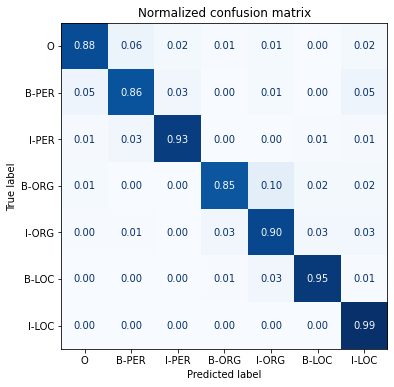

In [85]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names)

confuse the B-ORG and I-ORG entities the most

let’s move on and **look at sequences with high losses**. For this calculation, we’ll revisit our “unexploded” DataFrame and **calculate the total loss by summing over the loss per token**. To do this, let’s first write a function that helps us display the token sequences with the labels and the losses:

In [86]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels,
                               "preds": preds, "losses": losses}).T
        yield df_tmp

In [87]:
df["total_loss"] = df["loss"].apply(sum)
# look at top 3 sentences with highest CE loss
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

In [88]:
df_tmp

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens,total_loss
5009,"[0, 5106, 1019, 5, 19838, 5106, 152, 75198, 27...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, B-ORG, IGN, IGN, I-ORG, I-ORG, I-ORG, I-...","[0.0, 9.5688, 0.0, 0.0, 8.366348, 9.808468, 10...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-ORG,...","[<s>, ▁'', 8, ., ▁Juli, ▁'', ▁:, ▁Protest, cam...",84.777438
3558,"[0, 242, 5106, 18141, 15020, 5106, 242, 242, 5...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, O, O, IGN, O, O, B-LOC, I-LOC, I-LOC,...","[0.0, 0.00027998342, 0.0003777029, 1.6939306, ...","[O, O, O, B-ORG, O, O, O, O, O, O, O, O, O, O,...","[<s>, ▁', ▁'', ▁Τ, Κ, ▁'', ▁', ▁', ▁'', ▁T, ▁'...",75.252002
4671,"[0, 14098, 145704, 19335, 157955, 91969, 3674,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, B-PER, I-PER, I-PER, IGN, I-PER, IGN, I-...","[0.0, 6.0487304, 5.533558, 5.7249274, 0.0, 5.5...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-O...","[<s>, ▁United, ▁Nations, ▁Multi, dimensional, ...",59.884397


In [89]:
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,9.57,0.00,0.00,8.37,9.81,10.11,7.05,0.00,9.48,9.64,8.55,7.13,5.06,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,1.69,0.00,0.00,0.00,10.45,9.37,8.27,7.14,7.22,0.00,7.37,7.23,0.00,8.59,7.92,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,6.05,5.53,5.72,0.00,5.58,0.00,5.45,0.00,5.15,5.30,5.53,5.24,5.09,5.23,0.00


- Some labels are wrong(United Nations is a person?)
    - annotations for the PAN-X dataset were generated through an automated process.

Look at parenthesis and slashes examples (where there's an opening parenthesis `(`)

In [90]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.03,0.00,0.02,0.02,0.03,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.03,0.00,0.00,0.02,0.02,0.00,0.02,0.00


- The location is inside the parentheses, so the parenthesis is labeled as LOC as well
- we might want disconnect it from the original location in the annotations
- Data is collected from wikipedia multiple languages, so **more often wikipedia will have article titles often containing some sort of explanation in parentheses**

# Cross-lingual transfer

we have fine-tuned XLM-R on German, we can evaluate its ability to transfer to other languages via the predict() method of the Trainer

In [91]:
batch_size=12

In [92]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [93]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset: 0.866


Checking on French


In [94]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


In [95]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])

In [96]:
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-b155fa8d1ee747f3.arrow
Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-c96c80b619ee3678.arrow
Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-c8b056551bc4d569.arrow


F1-score of [de] model on [fr] dataset: 0.702


we see a drop of about 15 points in the micro-averaged metrics, remember that our model has not seen a single labeled French example

=> size of the performance drop is related to how “far away” the languages are from each other
    - Indo-European languages, they technically belong to different language families: Germanic and Romance, respectively.

Checking on Italian (also a Romance language, like French)

In [97]:
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-6b6e00b5f6b031e4.arrow
Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-134dd5df028b892e.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

F1-score of [de] model on [it] dataset: 0.678


Check on English (Germanic language family)

In [98]:
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")


Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-98734a1056b4cd18.arrow
Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-a6d97d034e66fcb1.arrow
Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-58411fa278cc6fe8.arrow


F1-score of [de] model on [en] dataset: 0.597


# When to use Zero-shot transfer

The question is, how good are these results and how do they compare against an XLM-R model fine-tuned on a monolingual corpus?

we will explore this question for the **French** corpus by fine-tuning XLM-R on training sets of increasing size, which in practice can be useful for guiding decisions about whether to collect more labeled data.

we’ll keep the same hyperparameters from the fine-tuning run on the German corpus, except that we’ll tweak the logging_steps argument of Training​Ar⁠guments to account for the changing training set sizes.

simple function that takes a DatasetDict object corresponding to a monolingual corpus, downsamples it by num_samples, and fine-tunes XLM-R on that sample to return the metrics from the best epoch:

In [99]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds) // batch_size

    trainer = Trainer(model_init=model_init, args=training_args,
        data_collator=data_collator, compute_metrics=compute_metrics,
        train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
    trainer.train()
#     if training_args.push_to_hub:
#         trainer.push_to_hub(commit_message="Training completed!")

    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]})

In [102]:
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-7077f32b8a439dce.arrow
Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-d233b9514858a421.arrow
Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-271f03ea5f605d61.arrow


Train with multiple sample size

In [100]:
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

Loading cached shuffled indices for dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-efb4c97d0cfc0aaf.arrow
/home/quan/anaconda3/envs/fastai_v2/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/quan/anaconda3/envs/fastai_v2/lib/python3.8/site-packages/torch/nn/modules/module.py:998: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return

Epoch,Training Loss,Validation Loss,F1
1,1.761700,1.308858,0.064724
2,1.264300,1.144619,0.174922
3,1.091400,1.032095,0.168708


,num_samples,f1_score
0,250,0.165449


In [ ]:
for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = metrics_df.append(
        train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)

In [102]:
metrics_df

,num_samples,f1_score
0,250,0.165449
1,500,0.643951
2,1000,0.759887
3,2000,0.798048


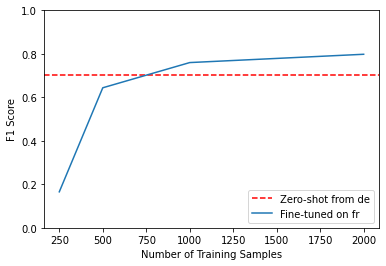

In [103]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

In [106]:
panx_de_encoded['train']

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 12580
})

- zero-shot transfer remains competitive until about 750 training examples
- zero-shot transfer is trained on 12580 German data, while fine-tune model is trained on around 750 French data to reach same f1 score on validation set
- this zero-shot transfer is still promising: In our experience, getting domain experts to label even hundreds of documents can be costly, especially for NER, where the labeling process is fine-grained and time-consuming.



# Fine-Tuning on Multiple Languages at Once

## Concatenate dataset

use the concatenate_datasets() function from HuggingFace Datasets to concatenate the German and French corpora together:

In [103]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets(
            [corpus[split] for corpus in corpora]).shuffle(seed=42)
    return multi_corpus

In [104]:
panx_de_encoded, panx_fr_encoded

(DatasetDict({
     train: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 12580
     })
     validation: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 6290
     })
     test: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 6290
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 4580
     })
     validation: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 2290
     })
     test: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 2290
     })
 }))

In [105]:
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

Loading cached shuffled indices for dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-a45db90d8976005d.arrow
Loading cached shuffled indices for dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-027faa8044923ad4.arrow
Loading cached shuffled indices for dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-3c051681789bf1d4.arrow


In [106]:
panx_de_fr_encoded

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 17160
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 8580
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 8580
    })
})

## train model

In [107]:
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.push_to_hub = False
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_encoded["train"],
    eval_dataset=panx_de_fr_encoded["validation"])

In [108]:
trainer.train()

/home/quan/anaconda3/envs/fastai_v2/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/quan/anaconda3/envs/fastai_v2/lib/python3.8/site-packages/torch/nn/modules/module.py:998: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return a "
/home/quan/anaconda3/envs/fastai_v2/lib/python3.8/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is dep

Epoch,Training Loss,Validation Loss,F1
1,No log,0.176410,0.834339
2,0.217500,0.156061,0.850841
3,0.217500,0.161216,0.861809


TrainOutput(global_step=2145, training_loss=0.1762014713598576, metrics={'train_runtime': 178.5427, 'train_samples_per_second': 288.334, 'train_steps_per_second': 12.014, 'total_flos': 1140291491923584.0, 'train_loss': 0.1762014713598576, 'epoch': 3.0})

In [109]:
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-98a1e557d4b73663.arrow
Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-8b5c8586738b5484.arrow
Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-c2045239f83cd18a.arrow


Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-7077f32b8a439dce.arrow
Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-d233b9514858a421.arrow
Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-271f03ea5f605d61.arrow


F1-score of [de-fr] model on [de] dataset: 0.872


Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-e1449a5a04a2fb57.arrow
Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-ec7e6d6f11d8f838.arrow
Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-899a54fb46395a98.arrow


F1-score of [de-fr] model on [fr] dataset: 0.855


Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-98734a1056b4cd18.arrow
Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-a6d97d034e66fcb1.arrow
Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-58411fa278cc6fe8.arrow


F1-score of [de-fr] model on [it] dataset: 0.795
F1-score of [de-fr] model on [en] dataset: 0.669


It performs much better on the French split than before, matching the performance on the German test set. Interestingly, its performance on the Italian and English splits also improves by roughly 10 points!

## comparing the performance of fine-tuning on each language separately against multilingual learning on all the corpora

In [110]:
training_args

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=IntervalStrategy.EPOCH,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=HubStrategy.EVERY_SAVE,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_metrics=False,
label_names=None,
label_smoothing_factor=0.0,
learning_rat

In [111]:
batch_size=12

In [112]:
corpora = [panx_de_encoded]

# Exclude German from iteration
for lang in langs[1:]:
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    # Fine-tune on monolingual corpus
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
    # Collect F1-scores in common dict
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # Add monolingual corpus to list of corpora to concatenate
    corpora.append(ds_encoded)

Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-7077f32b8a439dce.arrow
Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-d233b9514858a421.arrow
Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-271f03ea5f605d61.arrow
Loading cached shuffled indices for dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-efb4c97d0cfc0aaf.arrow


Epoch,Training Loss,Validation Loss,F1
1,No log,0.321250,0.789412
2,0.421100,0.273673,0.829170
3,0.421100,0.279438,0.837592


Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-e1449a5a04a2fb57.arrow
Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-ec7e6d6f11d8f838.arrow
Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-899a54fb46395a98.arrow
Loading cached shuffled indices for dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-a30240633bf072e8.arrow


Epoch,Training Loss,Validation Loss,F1
1,No log,0.317858,0.747385
2,0.563900,0.269459,0.791616
3,0.563900,0.252727,0.808597


Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-98734a1056b4cd18.arrow
Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-a6d97d034e66fcb1.arrow
Loading cached processed dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-58411fa278cc6fe8.arrow
Loading cached shuffled indices for dataset at /home/quan/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-f20aa3b0d727f989.arrow


Epoch,Training Loss,Validation Loss,F1
1,No log,0.520126,0.501027
2,0.802200,0.450325,0.619794
3,0.802200,0.402534,0.677778


In [113]:
corpora

[DatasetDict({
     train: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 12580
     })
     validation: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 6290
     })
     test: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 6290
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 4580
     })
     validation: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 2290
     })
     test: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 2290
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 1680
     })
     validation: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 840
     })
    

Now that we’ve fine-tuned on each language’s corpus, the next step is to concatenate all the splits together to create a multilingual corpus of all four languages

In [115]:
corpora_encoded = concatenate_splits(corpora)

In [116]:
corpora_encoded

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 20020
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10010
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10010
    })
})

In [117]:
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
    eval_dataset=corpora_encoded["validation"])

trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,0.189392,0.810414
2,0.228200,0.175059,0.842264
3,0.228200,0.173889,0.852478


TrainOutput(global_step=2505, training_loss=0.1864429466262787, metrics={'train_runtime': 209.4885, 'train_samples_per_second': 286.698, 'train_steps_per_second': 11.958, 'total_flos': 1312991477886144.0, 'train_loss': 0.1864429466262787, 'epoch': 3.0})

In [118]:
for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])

In [119]:
scores_data = {"de": f1_scores["de"],
               "each": {lang: f1_scores[lang][lang] for lang in langs},
               "all": f1_scores["all"]}
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on",
                         inplace=True)
f1_scores_df

Evaluated on,de,fr,it,en
Fine-tune on,,,,
de,0.8664,0.7018,0.6779,0.5971
each,0.8664,0.8350,0.8115,0.7094
all,0.8613,0.8651,0.8515,0.7544


# Conclusion

- Multilingual learning can provide significant gains in performance, especially if the low-resource languages for cross-lingual transfer belong to similar language families. 
    - In our experiments we can see that **German, French, and Italian achieve similar performance in the all category**
     => suggesting that these languages are **more similar to each other than to English.**


- As a general strategy, it is a good idea to **focus attention on cross-lingual transfer *within language families***, especially when dealing with different scripts like Japanese.

- this good performance generally **does not occur if the target language is significantly different from the one the base model was fine-tuned** on or was **not one of the 100 languages used during pretraining**.
    - MAD-X are designed precisely for these low-resource scenarios, and since MAD-X is built on top of nlpt_pin01 Transformers you can easily adapt the code in this chapter to work with it